In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
from os.path import join
import re
import time
import argparse
import pickle

# in-house tools
import gdreg

import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
JOB = "compute_score"
PGEN_FILE = "/n/groups/price/martin/data_GDREG/toy_10K/chr@_v1.SPB.hg19.toy_10K"
LD_FILE = "/n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_ld/toy_10K.c1_s0_e4232_ld.npz"
ANNOT_FILE = "/n/groups/price/martin/data_GDREG/toy_10K/toy.chr@.annot.gz," + \
    "/n/groups/price/martin/data_GDREG/toy_10K/toy.gene.chr@.pannot_mat.npz," + \
    "/n/groups/price/martin/data_GDREG/toy_10K/toy.proxy.chr@.pannot_mat.npz"
PREFIX_OUT = "/n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_score/toy_10K"

# Filler
SCORE_FILE = None
SUMSTATS_FILE = None
SNP_RANGE = None
MEMORY = 256
RANDOM_SEED = 0
FLAG_FULL_LD = False
FLAG_CROSS_TERM = True

In [3]:
sys_start_time = time.time()

###########################################################################################
######                                    Parse Options                              ######
###########################################################################################

# JOB = args.job
# PGEN_FILE = args.pgen_file
# LD_FILE = args.ld_file
# SCORE_FILE = args.score_file
# SUMSTATS_FILE = args.sumstats_file
# ANNOT_FILE = args.annot_file
# PREFIX_OUT = args.prefix_out
# SNP_RANGE = args.snp_range
# MEMORY = args.memory
# RANDOM_SEED = args.random_seed
# FLAG_FULL_LD = args.flag_full_ld
# FLAG_CROSS_TERM = args.flag_cross_term

# Parse and check arguments
LEGAL_JOB_LIST = ["get_snp_block", "compute_ld", "compute_score", "regress"]
err_msg = "# run_gdreg: --job=%s not supported" % JOB
assert JOB in LEGAL_JOB_LIST, err_msg

if JOB in ["compute_score"]:
    assert LD_FILE is not None, "--ld_file required for --job=%s" % JOB
if JOB in ["regress"]:
    assert SCORE_FILE is not None, "--score_file required for --job=%s" % JOB
if JOB in ["regress"]:
    assert SUMSTATS_FILE is not None, "--sumstats_file required for --job=%s" % JOB
if JOB in ["compute_score", "regress"]:
    assert ANNOT_FILE is not None, "--annot_file required for --job=%s" % JOB
if JOB in ["compute_ld"]:
    assert SNP_RANGE is not None, "--snp_range required for --job=%s" % JOB
    DIC_RANGE = gdreg.util.parse_snp_range(SNP_RANGE)

# Print input options
header = gdreg.util.get_cli_head()
header += "Call: run_gdreg.py \\\n"
header += "--job %s\\\n" % JOB
header += "--pgen_file %s\\\n" % PGEN_FILE
header += "--ld_file %s\\\n" % LD_FILE
header += "--score_file %s\\\n" % SCORE_FILE
header += "--sumstats_file %s\\\n" % SUMSTATS_FILE
header += "--annot_file %s\\\n" % ANNOT_FILE
header += "--prefix_out %s\\\n" % PREFIX_OUT
header += "--snp_range %s\\\n" % SNP_RANGE
header += "--memory %d\\\n" % MEMORY
header += "--random_seed %d\\\n" % RANDOM_SEED
header += "--flag_full_ld %s\\\n" % FLAG_FULL_LD
header += "--flag_cross_term %s\n" % FLAG_CROSS_TERM
print(header)

******************************************************************************
* Gene-level directional effect regression (GDREG)
* Version 0.0.2
* Martin Jinye Zhang
* HSPH / Broad Institute
* MIT License
******************************************************************************
Call: run_gdreg.py \
--job compute_score\
--pgen_file /n/groups/price/martin/data_GDREG/toy_10K/chr@_v1.SPB.hg19.toy_10K\
--ld_file /n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_ld/toy_10K.c1_s0_e4232_ld.npz\
--score_file None\
--sumstats_file None\
--annot_file /n/groups/price/martin/data_GDREG/toy_10K/toy.chr@.annot.gz,/n/groups/price/martin/data_GDREG/toy_10K/toy.gene.chr@.pannot_mat.npz,/n/groups/price/martin/data_GDREG/toy_10K/toy.proxy.chr@.pannot_mat.npz\
--prefix_out /n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_score/toy_10K\
--snp_range None\
--memory 256\
--random_seed 0\
--flag_full_ld False\
--flag_cross_term True



In [4]:
###########################################################################################
######                                   Data Loading                                ######
###########################################################################################
# Load --pgen_file
if JOB in ["get_snp_block", "compute_ld", "compute_score", "regress"]:
    print("# Loading --pgen_file")
    dic_data = {}
    if "@" not in PGEN_FILE:
        temp_dic = gdreg.util.read_pgen(PGEN_FILE)
        dic_data[temp_dic["pvar"]["CHR"][0]] = temp_dic.copy()
    else:
        for CHR in range(1, 23):
            if os.path.exists(PGEN_FILE.replace("@", "%s" % CHR) + ".pgen"):
                dic_data[CHR] = gdreg.util.read_pgen(
                    PGEN_FILE.replace("@", "%s" % CHR)
                )

    for CHR in dic_data:
        n_sample = dic_data[CHR]["psam"].shape[0]
        n_snp = dic_data[CHR]["pvar"].shape[0]
        mat_X = gdreg.util.read_geno(
            dic_data[CHR]["pgen"], 0, 50, n_sample=None, n_snp=None
        )
        sparsity = (mat_X != 0).mean()
        print(
            "    CHR%2d: %d samples, %d SNPs, %0.1f%% non-zeros for first 50 SNPs"
            % (CHR, n_sample, n_snp, sparsity * 100)
        )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --ld_file
if JOB in ["compute_score"]:
    print("# Loading --ld_file")
    assert os.path.exists(LD_FILE), "--ld_file does not exist"
    mat_ld, dic_range = gdreg.util.read_ld(LD_FILE)
    if dic_range["chr_ref"] is None:
        dic_range["chr_ref"] = dic_range["chr"]
    err_msg = "n_snp=%d, mismatch with --pgen_file" % mat_ld.shape[0]
    assert mat_ld.shape[0] == dic_data[dic_range["chr"]]["pvar"].shape[0], err_msg
    print(
        "    chr=%d, start=%d, end=%d, chr_ref=%d"
        % (
            dic_range["chr"],
            dic_range["start"],
            dic_range["end"],
            dic_range["chr_ref"],
        )
    )
    print("    n_snp=%d, n_snp_ref=%d" % (mat_ld.shape[1], mat_ld.shape[0]))
    print("    LD info loaded, matching --pgen_file")
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --score_file
if JOB in ["regress"]:
    print("# Loading --score_file")
    flist = sorted(gdreg.util.from_filepattern(SCORE_FILE))
    print("    find %d score files" % len(flist))
    df_score = None
    for fpath in flist:
        temp_df = pd.read_csv(fpath, sep="\t", index_col=None)

        if df_score is None:
            df_score = temp_df.copy()
        else:
            df_score = pd.concat([df_score, temp_df], axis=0)

    df_score.sort_values(["CHR", "BP"], inplace=True)
    df_score.index = df_score["SNP"]
    LD_list = [x for x in df_score if x.startswith("LD:")]
    DLD_list = [x for x in df_score if x.startswith("DLD:")]

    print(
        "    score file loaded for %d SNPs, %d LD scores, %d DLD scores"
        % (df_score.shape[0], len(LD_list), len(DLD_list))
    )
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --sumstats_file
if JOB in ["regress"]:
    print("# Loading --sumstats_file")
    df_sumstats = pd.read_csv(SUMSTATS_FILE, sep="\t", index_col=None)
    print("    .sumstats.gz loaded, %d SNPs" % df_sumstats.shape[0])
    print("    " + gdreg.util.get_sys_info(sys_start_time))

# Load --annot_file (lazy loading)
if JOB in ["compute_score", "regress"]:
    print("# Loading --annot_file")
    dic_annot_path = {}
    dic_pannot_path = {}

    for annot_file in ANNOT_FILE.split(","):
        annot_name = gdreg.util.get_annot_name_from_file(annot_file)
        if annot_file.endswith(".annot.gz"):
            # Loading .annot.gz
            dic_annot_path[annot_name] = {}
            for CHR in range(1, 23):
                fpath = annot_file.replace("@", "%d" % CHR)
                if os.path.exists(fpath):
                    dic_annot_path[annot_name][CHR] = fpath
            # Checking .annot.gz
            CHR0 = list(dic_annot_path[annot_name])[0]
            col_list = list(
                gdreg.util.read_annot(dic_annot_path[annot_name][CHR0], nrows=5)
            )
            for CHR in dic_annot_path[annot_name]:
                temp_df = gdreg.util.read_annot(
                    dic_annot_path[annot_name][CHR], nrows=5
                )
                err_msg = "%s : columns mismatch between CHR%d and CHR%d" % (
                    annot_name,
                    CHR0,
                    CHR,
                )
                assert list(temp_df) == col_list, err_msg
            print(
                "    %s (%d CHRs) : columms match for all CHRs. Containing:"
                % (annot_name, len(dic_annot_path[annot_name]))
            )
            temp_str = ",".join([x for x in col_list if x.startswith("AN:")])
            print("        %s" % temp_str)

        if annot_file.endswith(".pannot_mat.npz"):
            # Loading .pannot_mat.npz
            dic_pannot_path[annot_name] = {}
            for CHR in range(1, 23):
                fpath = annot_file.replace("@", "%d" % CHR)
                if os.path.exists(fpath):
                    dic_pannot_path[annot_name][CHR] = fpath
            # Checking .pannot_mat.npz
            CHR = np.random.choice(list(dic_pannot_path[annot_name]), size=1)[0]
            mat_G = gdreg.util.read_pannot_mat(dic_pannot_path[annot_name][CHR])
            err_msg = "(%s, CHR%d) : n_snp=%d, mismatch with --pgen_file" % (
                annot_name,
                CHR,
                mat_G.shape[0],
            )
            assert mat_G.shape[0] == dic_data[CHR]["pvar"].shape[0], err_msg
            print(
                "    %s (%d CHRs) : CHR%d dimension matches with .pvar"
                % (annot_name, len(dic_pannot_path[annot_name]), CHR)
            )

    # Checking CHR_set
    if len(dic_annot_path) > 0:
        annot_name = list(dic_annot_path)[0]
        CHR_set = set(dic_annot_path[annot_name])
    else:
        annot_name = list(dic_pannot_path)[0]
        CHR_set = set(dic_pannot_path[annot_name])
    for annot_name in dic_annot_path:
        err_msg = "Set of CHRs does not match for %s" % annot_name
        assert set(dic_annot_path[annot_name]) == CHR_set, err_msg
    for annot_name in dic_pannot_path:
        err_msg = "Set of CHRs does not match for %s" % annot_name
        assert set(dic_pannot_path[annot_name]) == CHR_set, err_msg
    print(
        "    Detected %d CHRs for all files : %s"
        % (len(CHR_set), ",".join(["%d" % x for x in CHR_set]))
    )

# Loading --pgen_file
    CHR 1: 10000 samples, 4232 SNPs, 26.7% non-zeros for first 50 SNPs
    CHR 2: 10000 samples, 4056 SNPs, 43.5% non-zeros for first 50 SNPs
    CHR 3: 10000 samples, 4067 SNPs, 33.9% non-zeros for first 50 SNPs
    CHR 4: 10000 samples, 4027 SNPs, 24.2% non-zeros for first 50 SNPs
    CHR 5: 10000 samples, 4106 SNPs, 36.7% non-zeros for first 50 SNPs
    CHR 6: 10000 samples, 4154 SNPs, 39.6% non-zeros for first 50 SNPs
    CHR 7: 10000 samples, 4071 SNPs, 41.8% non-zeros for first 50 SNPs
    CHR 8: 10000 samples, 3891 SNPs, 33.3% non-zeros for first 50 SNPs
    CHR 9: 10000 samples, 4149 SNPs, 40.1% non-zeros for first 50 SNPs
    CHR10: 10000 samples, 4129 SNPs, 40.3% non-zeros for first 50 SNPs
    sys_time=0.4s, sys_mem=0.11GB
# Loading --ld_file
    chr=1, start=0, end=4232, chr_ref=1
    n_snp=4232, n_snp_ref=4232
    LD info loaded, matching --pgen_file
    sys_time=0.7s, sys_mem=0.16GB
# Loading --annot_file
    AN:toy (10 CHRs) : columms match for all 

In [5]:
if JOB == "compute_score":
    CHR, START, END = dic_range["chr"], dic_range["start"], dic_range["end"]
    n_snp = dic_data[CHR]["pvar"].shape[0]

    # Zero pad for mat_ld
    mat_ld_list = []
    if START > 0:
        mat_ld_list.append(
            sp.sparse.csc_matrix(
                ([0], ([0], [0])), shape=[n_snp, START], dtype=np.float32
            )
        )
    mat_ld_list.append(mat_ld)
    if END < n_snp:
        mat_ld_list.append(
            sp.sparse.csc_matrix(
                ([0], ([0], [0])), shape=[n_snp, n_snp - END], dtype=np.float32
            )
        )
    dic_ld = {CHR: sp.sparse.hstack(mat_ld_list, format="csc")}
    snp_range = (dic_range["chr"], dic_range["start"], dic_range["end"])

    df_score = gdreg.score.compute_score(
        dic_data,
        dic_ld,
        dic_annot_path,
        dic_pannot_path,
        flag_cross_term=FLAG_CROSS_TERM,
        verbose=True,
        win_size=1e7,
        snp_range=snp_range,
    )

#     df_score.to_csv(
#         PREFIX_OUT + ".c%d_s%d_e%d_score.tsv.gz" % (CHR, START, END),
#         sep="\t",
#         index=False,
#         compression="gzip",
#     )

# Call: gdreg.score.compute_score
    40882 SNPs (10 CHRs): CHR1 (4232), CHR2 (4056), CHR3 (4067), CHR4 (4027), CHR5 (4106), CHR6 (4154), CHR7 (4071), CHR8 (3891), CHR9 (4149), CHR10 (4129)
    Range: chr=1, start=0, end=4232 
    Annots : AN:CHR1t5_common, AN:CHR1t5_lf, AN:all_common, AN:all_lf
    Pannots : pAN:toy_gene, pAN:toy_proxy
    win_size=10.0MB, memory=1024MB
    Completed, time=18.1s


In [6]:
fpath = "/n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_score/toy_10K.c1_s0_e4232_score.tsv.gz"
df_score_ref = pd.read_csv(fpath, sep="\t", index_col=None)
for col in df_score:
    if col.startswith(("E", "LD")):
        print(col, np.corrcoef(df_score[col], df_score_ref[col])[0,1])
print("toy_proxy", np.corrcoef(df_score["DLD:pAN:toy_proxy"], df_score_ref["DLD:pAN:proxy"])[0,1])
print("toy_gene", np.corrcoef(df_score["DLD:pAN:toy_gene"], df_score_ref["DLD:pAN:gene"])[0,1])

E 1.0
LD:AN:CHR1t5_common 0.9986151305299155
LD:AN:CHR1t5_lf 0.9992656622564163
LD:AN:all_common 0.9938862534707935
LD:AN:all_lf 0.9963736993472094
toy_proxy 1.0
toy_gene 0.9999999999999998


In [7]:
fpath = "/n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_score/toy_10K.c1_s0_e4232_score.tsv.gz"
df_score_ref = pd.read_csv(fpath, sep="\t", index_col=None)
for col in df_score:
    if col.startswith(("E", "LD")):
        print(col, np.corrcoef(df_score[col], df_score_ref[col])[0,1])
    

E 1.0
LD:AN:CHR1t5_common 0.9986151305299155
LD:AN:CHR1t5_lf 0.9992656622564163
LD:AN:all_common 0.9938862534707935
LD:AN:all_lf 0.9963736993472094


In [8]:
np.corrcoef(df_score["DLD:pAN:toy_proxy"], df_score_ref["DLD:pAN:proxy"])[0,1]

1.0

### Test cross term

In [9]:
df_annot = None
for CHR in dic_annot_path["AN:toy"]:
    temp_df = gdreg.util.read_annot(dic_annot_path["AN:toy"][CHR].replace('@', "%d" % CHR))
    if df_annot is None:
        df_annot = temp_df.copy()
    else:
        df_annot = pd.concat([df_annot, temp_df], axis=0)

In [10]:
# Read in all LD matrices 
dic_ld_full = {}
CHR,START,END = 1,0,4032
temp_path = "/n/groups/price/martin/data_GDREG/toy_10K/gdreg_file_fullld"
for CHR_REF in range(1,11):
    dic_ld_full[(CHR,CHR_REF)] = np.load(
        temp_path + '/toy_10K.c%d_r%d_fullld.npy' % (CHR, CHR_REF)
    )

df_score.index = df_score['SNP']
snp_list = [x for x in df_score['SNP'] if "|" not in x][:1000]
pair_list = [x for x in df_score['SNP'] if "|" in x][:1000]
dic_ind = {x:i for i,x in enumerate(dic_data[CHR]['pvar']['SNP'])}
ind_snp =  [dic_ind[x] for x in snp_list]
ind_pair = [(dic_ind[x.split("|")[0]], dic_ind[x.split("|")[1]]) for x in pair_list]

In [11]:
# E score : SQ terms 
v_score = np.diag(dic_ld_full[(CHR,CHR)])[ind_snp]
print('SQ terms : abs_dif=%0.3g' % np.absolute(v_score - df_score.loc[snp_list, 'E'].values).sum())

# E score : Cross terms 
row_list = [x[0] for x in ind_pair]
col_list = [x[1] for x in ind_pair]
v_score = dic_ld_full[(CHR,CHR)][(row_list, col_list)]
print('Cross terms : abs_dif=%0.3g' % np.absolute(v_score - df_score.loc[pair_list, 'E'].values).sum())

SQ terms : abs_dif=0
Cross terms : abs_dif=0


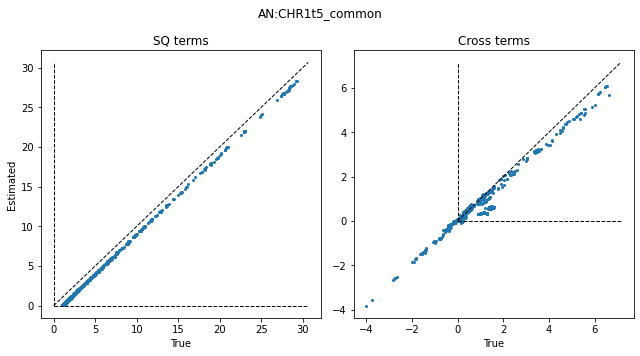

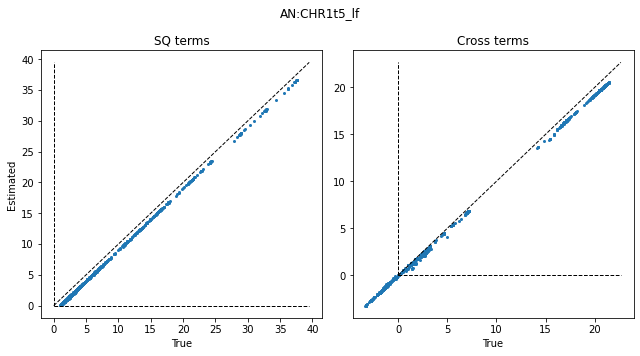

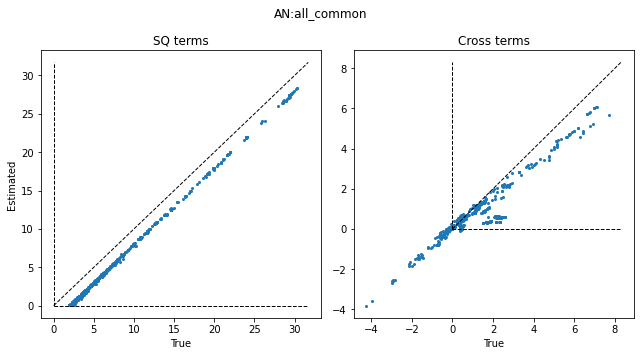

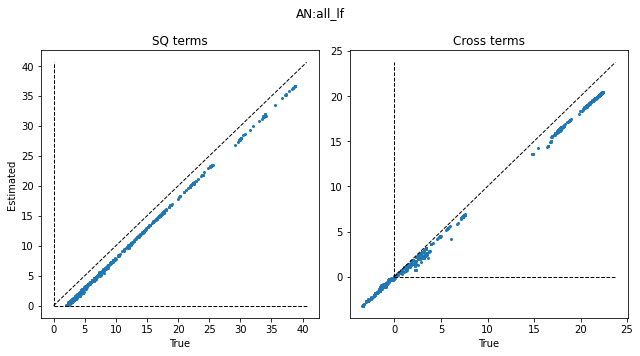

In [12]:
# LD score
mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
for AN in ['AN:CHR1t5_common', 'AN:CHR1t5_lf', 'AN:all_common', 'AN:all_lf']:
    plt.figure(figsize=[9,5])
    v_annot = df_annot[AN].values
    
    # SQ terms 
    v_ld_score = ((mat_ld_chr**2).T*v_annot).sum(axis=1)[ind_snp]

    plt.subplot(121)
    plt.scatter(v_ld_score, df_score.loc[snp_list, 'LD:%s'%AN], s=4)
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, max_], [0, max_], '--', color='k', linewidth=1)
    plt.plot([0, max_], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, max_], '--', color='k', linewidth=1)
    plt.title('SQ terms')
    plt.xlabel('True')
    plt.ylabel('Estimated')
    
    # Cross terms 
    v_ld_score = []
    for i,j in ind_pair:
        v_ld_score.append((mat_ld_chr[:,i] * mat_ld_chr[:,j] * v_annot).sum())
    v_ld_score = np.array(v_ld_score)
    
    plt.subplot(122)
    plt.scatter(v_ld_score, df_score.loc[pair_list, 'LD:%s'%AN], s=4)
    x_max = max(v_ld_score.max(), df_score.loc[pair_list, 'LD:%s'%AN].max())
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, max_], [0, max_], '--', color='k', linewidth=1)
    plt.plot([0, max_], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, max_], '--', color='k', linewidth=1)
    plt.title('Cross terms')
    plt.xlabel('True')

    plt.suptitle(AN)
    plt.tight_layout()
    plt.show()

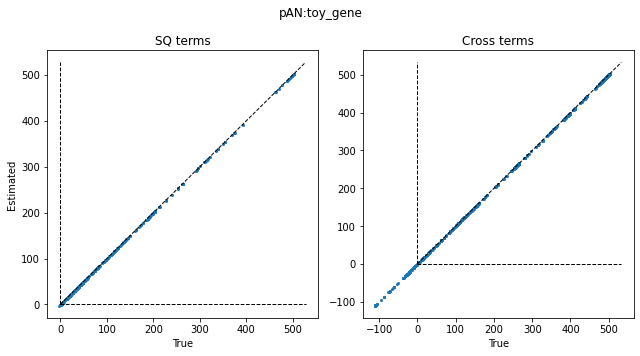

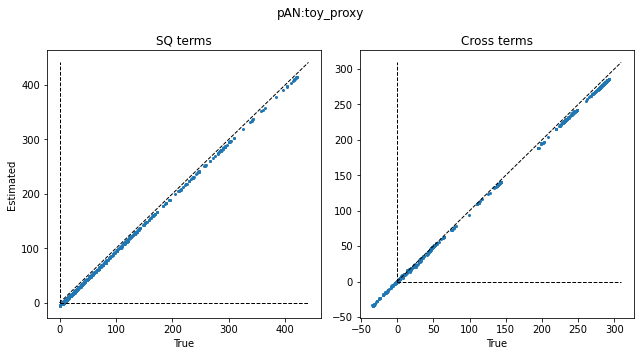

In [13]:
# DLD score using .pannot
for pAN in ['pAN:toy_gene', 'pAN:toy_proxy']:
    mat_ld_chr = np.concatenate([dic_ld_full[(CHR,x)] for x in range(1,11)], axis=0)
    mat_list = []
    for CHR_ in range(1,11):
        mat_list.append(gdreg.util.read_pannot_mat(dic_pannot_path[pAN][CHR_]))
    mat_G = sp.sparse.block_diag(mat_list)

    plt.figure(figsize=[9,5])

    # SQ terms 
    v_dld_score = (mat_G.dot(mat_ld_chr) * mat_ld_chr).sum(axis=0)[ind_snp]

    plt.subplot(121)
    plt.scatter(v_dld_score, df_score.loc[snp_list, 'DLD:%s' % pAN], s=4)
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, max_], [0, max_], '--', color='k', linewidth=1)
    plt.plot([0, max_], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, max_], '--', color='k', linewidth=1)
    plt.title('SQ terms')
    plt.xlabel('True')
    plt.ylabel('Estimated')

    # Cross terms 
    v_dld_score = []
    for i,j in ind_pair:
        v_dld_score.append((mat_G.dot(mat_ld_chr[:,i]) * mat_ld_chr[:,j]).sum())
    v_dld_score = np.array(v_dld_score)

    plt.subplot(122)
    plt.scatter(v_dld_score, df_score.loc[pair_list, 'DLD:%s' % pAN], s=4)
    max_ = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, max_], [0, max_], '--', color='k', linewidth=1)
    plt.plot([0, max_], [0, 0], '--', color='k', linewidth=1)
    plt.plot([0, 0], [0, max_], '--', color='k', linewidth=1)
    plt.title('Cross terms')
    plt.xlabel('True')

    plt.suptitle(pAN)
    plt.tight_layout()
    plt.show()